In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torchsummary import summary
import torch.nn.functional as F

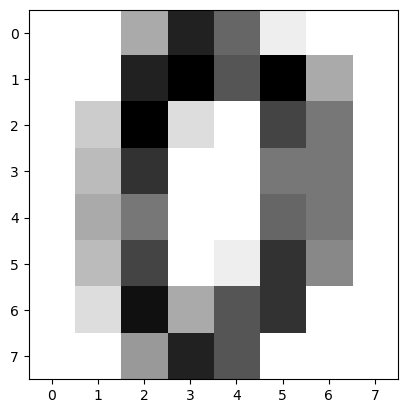

In [2]:
digits = datasets.load_digits()
plt.imshow(digits.images[0], cmap=plt.cm.gray_r, interpolation='nearest')

In [3]:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, 1, 8, 8)) 

In [4]:
X_train, X_test, y_train, y_test = train_test_split(data, digits.target, test_size=0.2)

In [5]:
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long) 
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

In [6]:
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([1437, 1, 8, 8]),
 torch.Size([360, 1, 8, 8]),
 torch.Size([1437]),
 torch.Size([360]))

In [8]:
class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1) 
        self.pool = nn.MaxPool2d(2, 2) 
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) 
        self.fc1 = nn.Linear(32 * 2 * 2, 64)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, 10) 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) 
        x = self.pool(F.relu(self.conv2(x))) 
        x = x.view(-1, 32 * 2 * 2) 
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [9]:
model = CNNClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
train_losses = []
test_accuracies = []
num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        optimizer.zero_grad() # gradient 초기화
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward() #gradient 계산
        optimizer.step() #파라미터 업데이트
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            predicted = torch.argmax(outputs, dim=1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

print("Training complete.")

Epoch 1/30, Loss: 1.9092, Accuracy: 76.11%
Epoch 2/30, Loss: 0.9393, Accuracy: 92.22%
Epoch 3/30, Loss: 0.4979, Accuracy: 95.00%
Epoch 4/30, Loss: 0.3318, Accuracy: 95.28%
Epoch 5/30, Loss: 0.2476, Accuracy: 97.50%
Epoch 6/30, Loss: 0.1950, Accuracy: 97.50%
Epoch 7/30, Loss: 0.1547, Accuracy: 97.22%
Epoch 8/30, Loss: 0.1298, Accuracy: 98.33%
Epoch 9/30, Loss: 0.1172, Accuracy: 97.50%
Epoch 10/30, Loss: 0.1131, Accuracy: 98.06%
Epoch 11/30, Loss: 0.0674, Accuracy: 98.61%
Epoch 12/30, Loss: 0.0821, Accuracy: 97.22%
Epoch 13/30, Loss: 0.0647, Accuracy: 97.22%
Epoch 14/30, Loss: 0.0790, Accuracy: 97.78%
Epoch 15/30, Loss: 0.0458, Accuracy: 98.33%
Epoch 16/30, Loss: 0.0483, Accuracy: 97.50%
Epoch 17/30, Loss: 0.0523, Accuracy: 98.06%
Epoch 18/30, Loss: 0.0565, Accuracy: 98.06%
Epoch 19/30, Loss: 0.0316, Accuracy: 97.50%
Epoch 20/30, Loss: 0.0436, Accuracy: 98.33%
Epoch 21/30, Loss: 0.0317, Accuracy: 98.89%
Epoch 22/30, Loss: 0.0252, Accuracy: 98.33%
Epoch 23/30, Loss: 0.0296, Accuracy: 99.1

In [15]:
# 모델 평가
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs) 

        _, predicted_indices = torch.max(outputs, 1) 

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted_indices.cpu().numpy()) 

all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions) 

conf_matrix = confusion_matrix(all_labels, all_predictions)


f1 = f1_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')


print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')

Confusion Matrix:
[[29  0  0  0  2  0  0  0  0  0]
 [ 0 40  0  0  0  0  0  0  0  0]
 [ 0  0 32  0  0  0  0  0  0  0]
 [ 0  0  0 36  0  0  0  0  0  0]
 [ 0  0  0  0 32  0  0  0  0  0]
 [ 0  0  0  0  0 43  0  0  0  0]
 [ 0  0  0  0  0  0 36  0  1  0]
 [ 0  0  0  0  0  0  0 42  0  0]
 [ 0  1  0  1  0  0  0  0 22  0]
 [ 0  1  0  1  0  0  0  0  0 41]]
F1 Score: 0.98
Precision: 0.98
Recall: 0.98


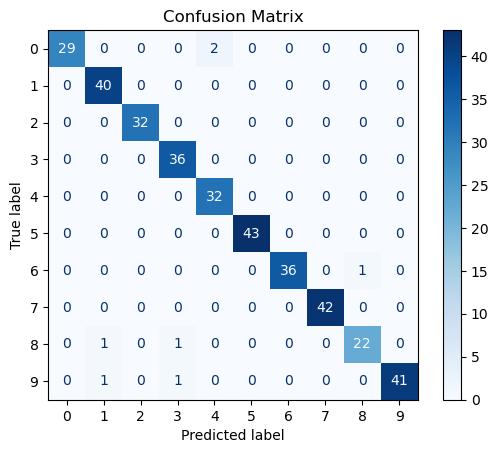

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay(conf_matrix).plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()